Durante el desarrollo del práctico, se va a trabajar con el **Fish Dataset**

# 1. Configuración del ambiente

In [2]:
# instalamos el paquete para descargar archivos
!pip install wget

# montar la unidad de google drive
from google.colab import drive
drive.mount('/content/gdrive/')

# crear las carpetas necesarias
from os import makedirs
datasets_folder = '/content/gdrive/My Drive/Colab Notebooks/DUIA/2020/Machine Learning/'
makedirs(datasets_folder, exist_ok=True)

# importo numpy
import numpy as np
np.set_printoptions(precision=3, suppress=True) # y hago un truco para imprimir solamente 3 decimales

# importo una librería para utilizar valores aleatorios
import random
random.seed(10)
np.random.seed(10)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# 2. Datos necesarios para trabajar

In [3]:
# importamos el paquete para descargar archivos
import wget
from os import path

# establecemos las características del data set
fish_dataset = dict()
fish_dataset['url'] = 'https://raw.githubusercontent.com/ignaciorlando/duia-ml-datasets/master/FishDataset/datasets_229906_491820_Fish.csv'
fish_dataset['extension'] = '.csv'
fish_dataset['filename'] = path.join(datasets_folder, 'fish_dataset' + fish_dataset['extension']) 
if not path.exists(fish_dataset['filename']):  # descargar solamente si no existe
  wget.download(fish_dataset['url'], fish_dataset['filename'])
else:
  print('El archivo {} ya existe.'.format(fish_dataset['filename']))


El archivo /content/gdrive/My Drive/Colab Notebooks/DUIA/2020/Machine Learning/fish_dataset.csv ya existe.


# 3. Explorar datos crudos

In [4]:
# abrimos el archivo utilizando una función específica de numpy 
# y lo colocamos en una matriz

#se cuantifica la columna categórica "Species"
species = ['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt']
cat = {
    specie: index for index, specie in enumerate(species)
}

raw_dataset = np.genfromtxt(fish_dataset['filename'], 
                            skip_header=1,
                            delimiter=",",
                            encoding='utf-8',
                            converters = {0: lambda x: float(cat.get(x, 100))})
# verificamos el tamaño de la matriz que abrimos (filas x columnas)
print('Dataset size: {}'.format(raw_dataset.shape))
# imprimimos las primeras 4 filas para ver qué tipo de datos tenemos
print('First 4 rows:')
print(raw_dataset[0:4,:])

Dataset size: (159, 7)
First 4 rows:
[[  0.    242.     23.2    25.4    30.     11.52    4.02 ]
 [  0.    290.     24.     26.3    31.2    12.48    4.306]
 [  0.    340.     23.9    26.5    31.1    12.378   4.696]
 [  0.    363.     26.3    29.     33.5    12.73    4.455]]


Este dataset tiene 7 especies distintas de peces que existen en el mercado.
Con este dataset, se puede realizar un modelo predictivo para estimar el peso de un pez.

Cada columna de nuestro conjunto de datos representa las siguientes features:
- **Species**: Nombre de la especie del pez
- **Length1**: Longitud vertical en cm
- **Length2**: Longitud diagonal en cm
- **Length3**: Longitud a lo largo en cm
- **Height**: Altura en cm
- **Width**: Ancho en cm 
- **Weight**: Peso del pez en gramos (grs)

Tenemos las etiquetas ('**Weight**', el peso de los peces) mezcladas con las features. La acción correctiva es separar esta variable.
Aplicamos entonces la acción correctiva, y construimos nuestra matriz de diseño y nuestro arreglo de etiquetas:

En el análisis de los datos (más adelante), se concluyó que las 3 features de longitud (**Length1, Length2 y Length3**) están fuertemente vinculadas, por lo cual se dejó sólo la feature **Length1** y se removieron las features **Length2 y Length3**.

In [5]:
# definimos un diccionario con tags para las features que vamos a mantener y sus
# descriptiones
feature_labels = dict()
feature_labels['Species']='especie del pez'
feature_labels['Length1']='longitud vertical (en cm)'
#feature_labels['Length2']='longitud diagonal (en cm)'
#feature_labels['Length3']='longitud a lo largo (en cm)'
feature_labels['Height']='altura (en cm)'
feature_labels['Width']='ancho (en cm)'
fish_dataset['feature-labels'] = feature_labels

print(feature_labels.keys())

# recuperamos únicamente las columnas que nos interesa mantener como features
X = raw_dataset[:,[0,2,5,6]]
# y armamos el arreglo de etiquetas
y = raw_dataset[:,1]

# chequeamos los tamaños de nuestros nuevos conjuntos
print('X size: {}'.format(X.shape))
print('y size: {}'.format(y.shape))
# imprimimos las primeras 4 filas
print('First 4 rows from the design matrix:')
print(X[0:4,:])
print('First 4 labels from the labels array:')
print(y[0:4])

dict_keys(['Species', 'Length1', 'Height', 'Width'])
X size: (159, 4)
y size: (159,)
First 4 rows from the design matrix:
[[ 0.    23.2   11.52   4.02 ]
 [ 0.    24.    12.48   4.306]
 [ 0.    23.9   12.378  4.696]
 [ 0.    26.3   12.73   4.455]]
First 4 labels from the labels array:
[242. 290. 340. 363.]


# 4. Particionar los datos

En este dataset, no contamos con identificadores que nos determinen de qué pez proviene cada muestra, con lo cual no podemos chequear si hay datos repetidos.

Se va a utilizar un 70% de los datos disponibles para entrenar/validar el algoritmo (training/validation sets), y un 30% para testear el resultado final (test set). Y para evitar un sesgo en la selección de nuestros datos, vamos a hacer particiones aleatorias. Además porque nuestros datos en el dataset están ordenados por especie, por lo cual necesitamos aleatorizarlos.

In [6]:
# calculamos la cantidad de muestras de entrenamiento/validación y test
n_trainval = round(0.7 * X.shape[0])
n_test = X.shape[0] - n_trainval

# vamos a generar una secuencia de índices de 0 al total de muestras, con la que
# representaremos cada muestra en nuestra matriz de diseño
idx = list(range(0,X.shape[0]))
print('First 5 indices (without shuffling): {}'.format(idx[0:5]))
# ahora vamos a aleatorizar el orden de esta lista, para que ya no sean 
# consecutivos
random.shuffle(idx)
print('First 5 indices (after shuffling): {}'.format(idx[0:5]))
# si extraemos las primeras n_trainval muestras de X usando los índices
# aleatorizados que hemos generado, esto equivale a tomar unas muestra aleatoria
X_trainval = X[idx[0:n_trainval],:]
y_trainval = y[idx[0:n_trainval]]
X_test = X[idx[n_trainval:],:]
y_test = y[idx[n_trainval:]]
# verificamos sus tamaños
print('Train/val set size: {}'.format(X_trainval.shape))
print('Test set size: {}'.format(X_test.shape))

First 5 indices (without shuffling): [0, 1, 2, 3, 4]
First 5 indices (after shuffling): [91, 88, 36, 50, 69]
Train/val set size: (111, 4)
Test set size: (48, 4)


De ese 70% de datos que separamos para entrenar/validar el algoritmo, nos quedaremos con un 90% para entrenar el algoritmo (training set), y el 10% restante para validar las configuraciones (validation set). Igual que antes, utilizaremos particiones aleatorias.

In [7]:
# calculamos la cantidad de muestras de entrenamiento y validación
n_train = round(0.9 * X_trainval.shape[0])
n_val = X_trainval.shape[0] - n_train

# si extraemos las primeras n_trainval muestras de X usando los índices
# aleatorizados que hemos generado, esto equivale a tomar unas muestra aleatoria
X_train = X[idx[0:n_train],:]
y_train = y[idx[0:n_train]]
X_val = X[idx[n_train:n_train+n_val],:]
y_val = y[idx[n_train:n_train+n_val]]
# verificamos sus tamaños
print('Training set size: {}'.format(X_train.shape))
print('Validation set size: {}'.format(X_val.shape))
print('Test set size: {}'.format(X_test.shape))

Training set size: (100, 4)
Validation set size: (11, 4)
Test set size: (48, 4)


Una vez que tenemos las particiones realizadas, vamos a chequear si los conjuntos no tienen algún sesgo. Para comparar las distribuciones vamos a utilizar un histograma.

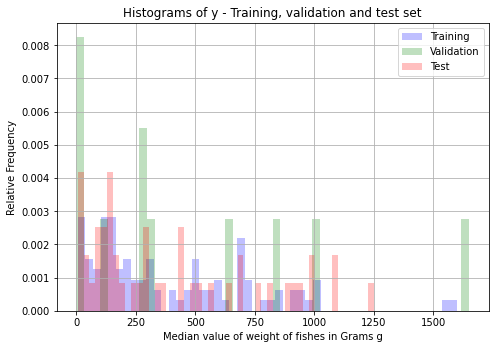

In [8]:
from matplotlib import pyplot as plt

relative_frequency = True
n_bins = 50

# creamos el canvas de la figura
fig=plt.figure()
# agregamos los ejes
ax=fig.add_axes([0,0,1,1])
# hacemos histogramas de 50 baldes para los datos de entrenamiento, validación y
# test, en los colores azul (b), verde (g) y rojo (r), con cierta transparencia 
# alpha
ax.hist(y_train, n_bins, density=relative_frequency, facecolor='b', alpha=0.25)
ax.hist(y_val, n_bins, density=relative_frequency, facecolor='g', alpha=0.25)
ax.hist(y_test, n_bins, density=relative_frequency, facecolor='r', alpha=0.25)
# agregamos las etiquetas de los ejes x e y
ax.set_xlabel('Median value of weight of fishes in Grams g')
if relative_frequency:
  ax.set_ylabel('Relative Frequency')
else:
  ax.set_ylabel('Absolute Frequency')
# le colocamos un título
ax.set_title('Histograms of y - Training, validation and test set')
# agregamos la leyenda
ax.legend(['Training', 'Validation', 'Test'])
ax.grid(True)
# lo mostramos por pantalla
plt.show()

Puede verse que los perfiles de las curvas son más o menos similares, con los valores más frecuentes para la variable objetivo (el peso de los peces) entre el 0 y 250 gramos.
Además dicha variable se distribuye mas o menos parecida en cada conjunto por lo que podemos decir que estamos entrenando el algoritmo con distribuciones representativas.

# 5. Análisis visual de los datos (de entrenamiento)

El siguiente paso es estudiar un poco los datos de entrenamiento, para conocer un poco más las features que estamos usando. 

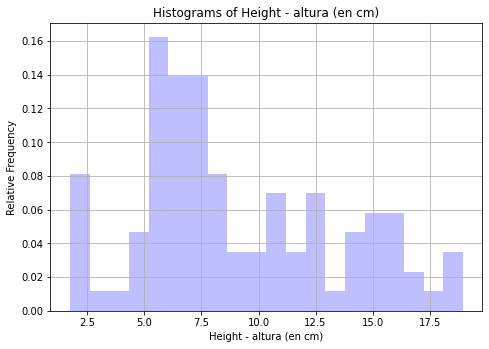

In [9]:
import matplotlib.pyplot as plt

# modificar esta variable con el índice de la feature que se quiere analizar
variable_to_print = 2
# modificar esta variable para determinar el número de baldes que vamos a usar
n_bins = 20
# recuperamos su tag y un string con su tag y descripción
tag = list(feature_labels.keys())[variable_to_print]
feature_id_and_description = tag + ' - ' + feature_labels[tag]

# creamos el canvas de la figura
fig=plt.figure()
# agregamos los ejes
ax=fig.add_axes([0,0,1,1])
# hacemos histogramas de 50 baldes para los datos de entrenamiento, validación y
# test, en los colores azul (b), verde (g) y rojo (r), con cierta transparencia 
# alpha
ax.hist(X_train[:,variable_to_print], n_bins, density=relative_frequency, facecolor='b', alpha=0.25)
# agregamos las etiquetas de los ejes x e y
ax.set_xlabel(feature_id_and_description)
if relative_frequency:
  ax.set_ylabel('Relative Frequency')
else:
  ax.set_ylabel('Absolute Frequency')
# le colocamos un título
ax.set_title('Histograms of {}'.format(feature_id_and_description))
ax.grid(True)
# lo mostramos por pantalla
plt.show()

A continuación, se estudian los datos mediante scatter plots (gráficos de dispersión), ya que nos permiten vincular dos o tres variables y observar en un espacio 2D o 3D qué relación tienen entre sí.

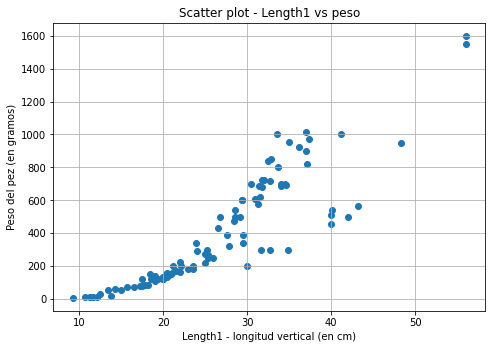

In [10]:
from matplotlib import pyplot as plt

# modificar esta variable con el índice de la feature que se quiere analizar
variable_to_print = 1
# recuperamos su tag y un string con su tag y descripción
tag = list(feature_labels.keys())[variable_to_print]
feature_id_and_description = tag + ' - ' + feature_labels[tag]
# generamos un scatter plot: por defecto, la variable objetivo la colocamos en 
# el eje Y, y a la variable cuya influencia queremos estudiar la colocamos en el 
# eje X
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(X_train[:,variable_to_print], y_train)
ax.grid(True)
ax.set_xlabel(feature_id_and_description)
ax.set_ylabel('Peso del pez (en gramos)')
ax.set_title('Scatter plot - {} vs peso'.format(tag))
plt.show()

Finalmente, y lo más representativo para este análisis, comparamos una feature con otra, para estudiar si ambas tienen alguna relación entre sí.

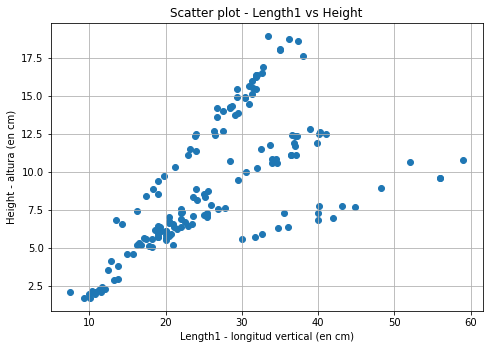

In [11]:
from matplotlib import pyplot as plt

# modificar esta variable con los índices de las características que queremos
# comparar
variables_to_compare = [1, 2]
# recuperamos los tags y las descripciones
tags = list([None]) * len(variables_to_compare)
features_ids_and_descriptions = list([None]) * len(variables_to_compare)
for i in range(len(variables_to_compare)):
  tags[i] = list(feature_labels.keys())[variables_to_compare[i]]
  features_ids_and_descriptions[i] = tags[i] + ' - ' + feature_labels[tags[i]]
# generamos un scatter plot
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(X[:,variables_to_compare[0]], X[:,variables_to_compare[1]])
ax.grid(True)
ax.set_xlabel(features_ids_and_descriptions[0])
ax.set_ylabel(features_ids_and_descriptions[1])
ax.set_title('Scatter plot - {} vs {}'.format(tags[0], tags[1]))
plt.show()

Comparando una feature con otra, se pudo observar:
- Que los peces mas pesados son los de la especie 0,2,4 y 5
- Que los peces mas livianos son de la especie 1 y 6
- Para las 3 features (Length1, Length2 y Length3), se puede observar que a medida que aumentan, aumenta el peso del pez (de forma lineal) y están muy vinculadas entre ellas.
- Lo anterior no es tan claro para la altura (Heigth) del pez, a pesar de que a medida que aumente gralmente aumenta el peso del pez, en el gráfico se observan 3 distintas ramas de crecimiento diferentes.

**La conclusión que se saca de estas comparaciones es que las 3 features de las longitudes están (logicamente) fuertemente relacionadas, por lo cual se van a eliminar 2 de ellas dejando sólo 1.**

# 6. Normalización y estandarización de los datos

Para evaluar los rangos, vamor a tomar el mínimo y máximo por columnas de nuestros datos de entrenamiento, y evaluar lo que obtenemos.

In [13]:
print('Training set statistics:')
print('Min values: {}'.format(np.min(X_train, axis=0)))
print('Max values: {}'.format(np.max(X_train, axis=0)))

Training set statistics:
Min values: [0.    9.3   1.739 1.048]
Max values: [ 6.    56.    18.957  7.796]


Puede verse que algunas features tienen rangos diferentes entre sí.
Para realizar la corrección sobre los datos vamos a normalizarlos aplicando la operación de **feature scaling**, que nos asegura que todas las features vivan en el intervalo [0, 1].
Vamos a verificar si conocemos el valor máximo/mínimo que puede tomar cada una de las features:

*   **Species** : Nombre de la especie del pez (son 7 categorías por lo que los valores van del 0 al 6)
*   **Length1** : Longitud del pez **(no conocemos el valor máximo)**
*   **Height** : Altura del pez **(no conocemos el valor máximo)**
*   **Width** : Anchura del pez **(no conocemos el valor máximo)**

Dado que tenemos varias variables a las que no les conocemos su valor máximo, vamos a normalizarlas estimando máximos y mínimos a partir de los datos de entrenamiento.

In [14]:
# calculamos los vectores de valores máximos y mínimos
max_values = np.max(X_train, axis=0)
min_values = np.min(X_train, axis=0)
# a cada fila de la matriz le restamos el valor mínimo y la dividimos por
X_train_norm = (X_train - min_values) / (max_values - min_values)
# chequeamos sus valores máximos y mínimos
print('X_train_norm')
print('Min: {}'.format(np.min(X_train_norm, axis=0)))
print('Max: {}'.format(np.max(X_train_norm, axis=0)))

X_train_norm
Min: [0. 0. 0. 0.]
Max: [1. 1. 1. 1.]


Ahora vamos a normalizar también los datos de validación y test

In [15]:
# repetimos en los datos de validación y test
X_val_norm = (X_val - min_values) / (max_values - min_values)
X_test_norm = (X_test - min_values) / (max_values - min_values)
# mostramos los valores máximos y mínimos
print('X_val_norm')
print('Min: {}'.format(np.min(X_val_norm, axis=0)))
print('Max: {}'.format(np.max(X_val_norm, axis=0)))
print('\n\nX_test_norm')
print('Min: {}'.format(np.min(X_test_norm, axis=0)))
print('Max: {}'.format(np.max(X_test_norm, axis=0)))

X_val_norm
Min: [0.167 0.024 0.02  0.049]
Max: [1.    1.064 0.617 0.953]


X_test_norm
Min: [ 0.    -0.039 -0.001  0.015]
Max: [1.    0.914 0.947 1.051]


Ahora bien, feature scaling es una de las opciones para corregir las asimetrías entre los datos. La otra (y la más recomendada) es la **estandarización**.

In [16]:
# estimamos media y desvío a partir de los datos de entrenamiento
mu = np.mean(X_train, axis=0)
sigma = np.std(X_train, axis=0)
# los imprimimos para ver cómo eran
print('X_train:')
print('Mean')
print(mu)
print('Std')
print(sigma)
# lo aplicamos sobre los datos de entrenamiento, validación y test
X_train_stand = (X_train - mu) / sigma
# imprimimos los valores que nos quedan ahora
print('\nX_train_stand:')
print('Mean')
print(np.mean(X_train_stand, axis=0))
print('Std')
print(np.std(X_train_stand, axis=0))

# repetimos la operación sobre los datos de validación y test
X_val_stand = (X_val - mu) / sigma
X_test_stand = (X_test - mu) / sigma

# salvamos los datos para usarlos más adelante
import pickle
print('\nSaving {}'.format(path.join(datasets_folder, 'fish_dataset_partitioned.pkl')))
with open(path.join(datasets_folder, 'fish_dataset_partitioned.pkl'), 'wb') as f:
    partitioned_dataset = {'X_train': X_train_stand, 'X_val': X_val_stand, 'X_test': X_test_stand,
                           'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
                           'feature_labels': feature_labels, 'mu': mu, 'sigma': sigma}
    pickle.dump(partitioned_dataset, f)


X_train:
Mean
[ 2.82  26.39   9.061  4.411]
Std
[2.066 9.45  4.374 1.593]

X_train_stand:
Mean
[ 0. -0.  0.  0.]
Std
[1. 1. 1. 1.]

Saving /content/gdrive/My Drive/Colab Notebooks/DUIA/2020/Machine Learning/fish_dataset_partitioned.pkl


Podemos ver ahora cómo nuestras muestras de entrenamiento han quedado centradas, y hemos aplicado el mismo criterio sobre los datos de validación y test.

Finalmente, vamos a observar cómo quedaron los datos de entrenamiento tras realizar la estandarización:

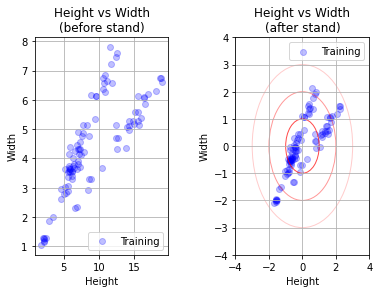

In [17]:
from matplotlib import pyplot as plt

# modificar esta variable con los índices de las características que queremos
# comparar
variables_to_compare = [2, 3]
tags = list([None]) * len(variables_to_compare)
for i in range(len(variables_to_compare)):
  tags[i] = list(feature_labels.keys())[variables_to_compare[i]]

# generamos un scatter plot con los datos antes de estandarizar
fig, (ax1, ax2) =plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.5)
ax1.scatter(X_train[:,variables_to_compare[0]], X_train[:,variables_to_compare[1]], facecolor='b', alpha=0.25)
ax1.grid(True)
ax1.set_xlabel(tags[0])
ax1.set_ylabel(tags[1])
ax1.legend(['Training'])
ax1.set_title('{} vs {}\n(before stand)'.format(tags[0], tags[1]))

# generamos un scatter plot con los datos estandarizados
ax2.scatter(X_train_stand[:,variables_to_compare[0]], X_train_stand[:,variables_to_compare[1]], facecolor='b', alpha=0.25)
circle1 = plt.Circle((0, 0), 1, color='r', alpha=0.7, fill=False)
circle2 = plt.Circle((0, 0), 2, color='r', alpha=0.4, fill=False)
circle3 = plt.Circle((0, 0), 3, color='r', alpha=0.2, fill=False)
ax2.add_artist(circle1)
ax2.add_artist(circle2)
ax2.add_artist(circle3)
ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4)
ax2.grid(True)
ax2.set_xlabel(tags[0])
ax2.set_ylabel(tags[1])
ax2.legend(['Training'])
ax2.set_title('{} vs {}\n(after stand)'.format(tags[0], tags[1]))

plt.show()

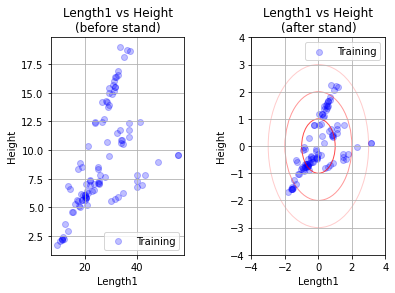

In [18]:
from matplotlib import pyplot as plt

# modificar esta variable con los índices de las características que queremos
# comparar
variables_to_compare = [1, 2]
tags = list([None]) * len(variables_to_compare)
for i in range(len(variables_to_compare)):
  tags[i] = list(feature_labels.keys())[variables_to_compare[i]]

# generamos un scatter plot con los datos antes de estandarizar
fig, (ax1, ax2) =plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.5)
ax1.scatter(X_train[:,variables_to_compare[0]], X_train[:,variables_to_compare[1]], facecolor='b', alpha=0.25)
ax1.grid(True)
ax1.set_xlabel(tags[0])
ax1.set_ylabel(tags[1])
ax1.legend(['Training'])
ax1.set_title('{} vs {}\n(before stand)'.format(tags[0], tags[1]))

# generamos un scatter plot con los datos estandarizados
ax2.scatter(X_train_stand[:,variables_to_compare[0]], X_train_stand[:,variables_to_compare[1]], facecolor='b', alpha=0.25)
circle1 = plt.Circle((0, 0), 1, color='r', alpha=0.7, fill=False)
circle2 = plt.Circle((0, 0), 2, color='r', alpha=0.4, fill=False)
circle3 = plt.Circle((0, 0), 3, color='r', alpha=0.2, fill=False)
ax2.add_artist(circle1)
ax2.add_artist(circle2)
ax2.add_artist(circle3)
ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4)
ax2.grid(True)
ax2.set_xlabel(tags[0])
ax2.set_ylabel(tags[1])
ax2.legend(['Training'])
ax2.set_title('{} vs {}\n(after stand)'.format(tags[0], tags[1]))

plt.show()

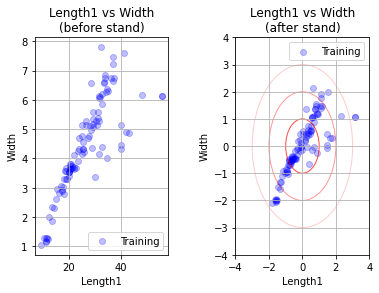

In [19]:
from matplotlib import pyplot as plt

# modificar esta variable con los índices de las características que queremos
# comparar
variables_to_compare = [1, 3]
tags = list([None]) * len(variables_to_compare)
for i in range(len(variables_to_compare)):
  tags[i] = list(feature_labels.keys())[variables_to_compare[i]]

# generamos un scatter plot con los datos antes de estandarizar
fig, (ax1, ax2) =plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.5)
ax1.scatter(X_train[:,variables_to_compare[0]], X_train[:,variables_to_compare[1]], facecolor='b', alpha=0.25)
ax1.grid(True)
ax1.set_xlabel(tags[0])
ax1.set_ylabel(tags[1])
ax1.legend(['Training'])
ax1.set_title('{} vs {}\n(before stand)'.format(tags[0], tags[1]))

# generamos un scatter plot con los datos estandarizados
ax2.scatter(X_train_stand[:,variables_to_compare[0]], X_train_stand[:,variables_to_compare[1]], facecolor='b', alpha=0.25)
circle1 = plt.Circle((0, 0), 1, color='r', alpha=0.7, fill=False)
circle2 = plt.Circle((0, 0), 2, color='r', alpha=0.4, fill=False)
circle3 = plt.Circle((0, 0), 3, color='r', alpha=0.2, fill=False)
ax2.add_artist(circle1)
ax2.add_artist(circle2)
ax2.add_artist(circle3)
ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4)
ax2.grid(True)
ax2.set_xlabel(tags[0])
ax2.set_ylabel(tags[1])
ax2.legend(['Training'])
ax2.set_title('{} vs {}\n(after stand)'.format(tags[0], tags[1]))

plt.show()

Podemos ver que la estandarización nos centró cerca del 0, y que efectivamente nuestros datos están contenidos dentro de los valores de desvíos esperados. 
A pesar de que queda claro que sólo se debe usar feature scaling si no se puede aplicar estandarización, de todas formas se aplicó para evaluarlo.